In [228]:
# External packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix
import datetime

In [229]:
%matplotlib inline

# Data Preprocessing

In [230]:
# Internal packages
from data_preprocess import *

In [231]:
df_all = concatenating_all_platform()
X, Y = creating_dataset(df_all)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


1 days    595
2 days    179
3 days    108
4 days     76
5 days     62
6 days     50
7 days     38
Name: delta, dtype: int64


In [236]:
print(X.shape)
X.head()

(410157, 9)


,Respondent ID,Device ID,Local Timestamp,Video Length,Time Of Day,Service,Action,Platform,Local Timestamp floored
57161,00005264-7d42-4b8f-a22a-a7a933c38656,2ba5ed42-7193-0660-9237-684b8fd1e799,2018-03-05 15:06:31,523.0,Afternoon,youtube,Play,Web,2018-03-05
59024,00005264-7d42-4b8f-a22a-a7a933c38656,2ba5ed42-7193-0660-9237-684b8fd1e799,2018-03-07 09:18:18,567.0,Morning,youtube,Play,Web,2018-03-07
59027,00005264-7d42-4b8f-a22a-a7a933c38656,2ba5ed42-7193-0660-9237-684b8fd1e799,2018-03-07 09:27:45,106.0,Morning,youtube,Play,Web,2018-03-07
59031,00005264-7d42-4b8f-a22a-a7a933c38656,2ba5ed42-7193-0660-9237-684b8fd1e799,2018-03-07 09:29:31,4.0,Morning,youtube,Play,Web,2018-03-07
61340,00005264-7d42-4b8f-a22a-a7a933c38656,2ba5ed42-7193-0660-9237-684b8fd1e799,2018-03-09 14:50:21,54.0,Afternoon,youtube,Play,Web,2018-03-09


In [235]:
print(Y.shape)
Y.head()

(1108, 4)


,Respondent ID,Platform,Time Of Day,Days
0,00005264-7d42-4b8f-a22a-a7a933c38656,Web,Late Evening,5
1,000e0929-bd36-441e-9368-db857aaf483c,Mobile,Late Night,1
2,002bf6f3-8a44-412a-a62a-30426faa4fff,Mobile,Afternoon,1
3,003749ec-8d02-4b4b-9bcd-6d1dbe450b4c,Mobile,Late Evening,1
4,0090dd2a-a97d-47fb-8879-dec95c7982ab,Mobile,Afternoon,1


# Building TS

In [7]:
# Internal packages
from build_timeseries import *

In [8]:
X["Local Timestamp"] = X["Local Timestamp"].dt.floor("H")
ts = build_empty_matrix(X)
X.groupby("Respondent ID").apply(lambda x: build_ts(x, ts))
ts_clean = outliers_cap(ts)
ts_norm = normalize_ts(ts_clean)

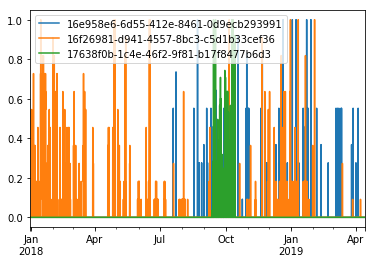

In [9]:
ts_norm[ts_norm.columns[100:103]].plot()

# CNN

In [10]:
# External packages
## SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
## Keras
from keras.models import Sequential, clone_model, Model, load_model
from keras.layers import concatenate, Dense, Activation, Conv2D, Conv1D, Input, MaxPooling1D, Flatten, Reshape, Dropout, UpSampling2D, Conv2DTranspose, UpSampling1D
from keras.utils import np_utils
from keras.activations import relu
from keras import metrics, backend as K, utils, optimizers

Using TensorFlow backend.


In [11]:
# size of TS
p = 1000

In [12]:
def find_last(ser):
    return ser[ser > 0].index.max()

last_dates = ts_clean.apply(find_last)
first_dates = last_dates - datetime.timedelta(hours = p)
date_int = pd.concat((first_dates, last_dates), axis=1)
date_int.head()
ts_cnn = pd.DataFrame(columns=ts_clean.columns, index=list(range(p)))
ts_cnn.fillna(0, inplace=True)
ts_cnn.head()

def fill_ts_cnn(ser):
    dates = date_int.loc[ser.name]
    temp = ser.copy()
    temp = temp[temp.index > dates[0]]
    temp = temp[temp.index <= dates[1]]
    temp = temp.values
    n = len(temp)
    temp = np.concatenate(([0] * (p - n), temp))
    ts_cnn[ser.name] = temp

ts_norm.apply(fill_ts_cnn)
ts_cnn = ts_cnn.T

In [13]:
ts_cnn.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
00005264-7d42-4b8f-a22a-a7a933c38656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.100000
000e0929-bd36-441e-9368-db857aaf483c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.333333
002bf6f3-8a44-412a-a62a-30426faa4fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000
003749ec-8d02-4b4b-9bcd-6d1dbe450b4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.133333,0.0,0.466667
0090dd2a-a97d-47fb-8879-dec95c7982ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.100000


# Autoencoder

In [14]:
input_ts = Input(shape=(p, 1))

x = Conv1D(4, kernel_size=20, activation='relu', padding='same')(input_ts)
x = MaxPooling1D(10, padding='same')(x)
x = Conv1D(4, 20, activation='relu', padding='same')(x)
x = MaxPooling1D(10, padding='same')(x)
encoded = Flatten()(x)
x = Reshape((10, -1))(encoded)
x = Conv1D(4, 20, activation='relu', padding='same')(x)
x = UpSampling1D(10)(x)
x = Conv1D(4, 20, activation='relu', padding='same')(x)
x = UpSampling1D(10)(x)
decoded = Dense(1, activation='relu')(x)

autoencoder = Model(input_ts, decoded)
autoencoder.summary()
adam = optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 4)           84        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 4)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 4)            324       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40)                0         
_________________________________________________________________
resh

In [238]:
X = ts_cnn.values.reshape(-1,p,1)
autoencoder.fit(X, X, epochs=200, batch_size=64)

Epoch 1/200
1108/1108 [==============================] - 0s 419us/step - loss: 0.0055
Epoch 2/200
1108/1108 [==============================] - 1s 473us/step - loss: 0.0055
Epoch 3/200
1108/1108 [==============================] - 1s 682us/step - loss: 0.0055
Epoch 4/200
1108/1108 [==============================] - 0s 439us/step - loss: 0.0055
Epoch 5/200
1108/1108 [==============================] - 0s 425us/step - loss: 0.0055
Epoch 6/200
1108/1108 [==============================] - 1s 454us/step - loss: 0.0055
Epoch 7/200
1108/1108 [==============================] - 1s 489us/step - loss: 0.0055
Epoch 8/200
1108/1108 [==============================] - 1s 472us/step - loss: 0.0055
Epoch 9/200
1108/1108 [==============================] - 0s 443us/step - loss: 0.0055
Epoch 10/200
1108/1108 [==============================] - 1s 573us/step - loss: 0.0055
Epoch 11/200
1108/1108 [==============================] - 1s 453us/step - loss: 0.0055
Epoch 12/200
1108/1108 [============================

1108/1108 [==============================] - 0s 427us/step - loss: 0.0054
Epoch 96/200
1108/1108 [==============================] - 0s 431us/step - loss: 0.0054
Epoch 97/200
1108/1108 [==============================] - 0s 390us/step - loss: 0.0054
Epoch 98/200
1108/1108 [==============================] - 0s 448us/step - loss: 0.0054
Epoch 99/200
1108/1108 [==============================] - 0s 445us/step - loss: 0.0054
Epoch 100/200
1108/1108 [==============================] - 1s 473us/step - loss: 0.0054
Epoch 101/200
1108/1108 [==============================] - 0s 421us/step - loss: 0.0054
Epoch 102/200
1108/1108 [==============================] - 0s 443us/step - loss: 0.0054
Epoch 103/200
1108/1108 [==============================] - 0s 431us/step - loss: 0.0054
Epoch 104/200
1108/1108 [==============================] - 0s 426us/step - loss: 0.0054
Epoch 105/200
1108/1108 [==============================] - 0s 395us/step - loss: 0.0054
Epoch 106/200
1108/1108 [=========================

1108/1108 [==============================] - 1s 504us/step - loss: 0.0054
Epoch 189/200
1108/1108 [==============================] - 0s 445us/step - loss: 0.0054
Epoch 190/200
1108/1108 [==============================] - 0s 427us/step - loss: 0.0054
Epoch 191/200
1108/1108 [==============================] - 0s 420us/step - loss: 0.0054
Epoch 192/200
1108/1108 [==============================] - 0s 410us/step - loss: 0.0054
Epoch 193/200
1108/1108 [==============================] - 0s 405us/step - loss: 0.0054
Epoch 194/200
1108/1108 [==============================] - 0s 427us/step - loss: 0.0054
Epoch 195/200
1108/1108 [==============================] - 1s 498us/step - loss: 0.0054
Epoch 196/200
1108/1108 [==============================] - 1s 502us/step - loss: 0.0054
Epoch 197/200
1108/1108 [==============================] - 0s 424us/step - loss: 0.0054
Epoch 198/200
1108/1108 [==============================] - 0s 424us/step - loss: 0.0054
Epoch 199/200
1108/1108 [=====================

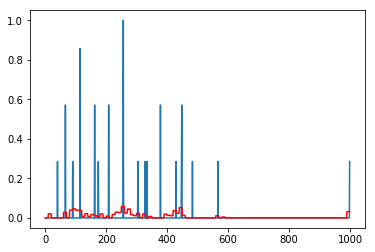

In [239]:
plt.close()
i = np.random.randint(1000)
plt.plot(X[i])
plt.plot(autoencoder.predict(X[i].reshape(-1, p, 1))[0], c='r')
plt.savefig("./viz/Fig_Autoencoder_TS6.png", dpi = 300)
plt.show()

In [240]:
encoder = Model(inputs=autoencoder.input, outputs=encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 4)           84        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 4)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 4)            324       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40)                0         
Total params: 408
Trainable params: 408
Non-trainable params: 0
_________________________________________________________________


# Clustering

In [241]:
# External packages
from sklearn.cluster import KMeans

In [464]:
n_clusters = 4
X_encoded = encoder.predict(X)
behaviour_clusters = KMeans(n_clusters=n_clusters, random_state=20).fit_predict(X_encoded)
n_customers = len(behaviour_clusters)
rgba = lambda x: plt.get_cmap("rainbow")(x / n_clusters)

In [465]:
clusters = []
for cluster_k in range(n_clusters):
    cluster = np.where(behaviour_clusters == cluster_k)
    clusters.append(cluster[0])

def plot_some_customers(k, n = 3):
    if (k >= len(clusters)):
        print("No cluster found for k = {}".format(k))
        return
    cluster = clusters[k]
    n_members = len(clusters[k])
    print("Category #{} has {} members ({}%)".format(k + 1, n_members, round(100 * n_members / n_customers)))
    print("Here are some of them :")
    for i in range(n):
        some_customer_in_cluster_k = cluster[np.random.randint(len(cluster))]
        plt.figure()
        plt.plot(X[some_customer_in_cluster_k], c=rgba(k))
        plt.show()
        
def compare_two_clusters(k1, k2, n = 3):
    plt.figure()
    cluster_1 = clusters[k1]
    some_customer_1 = cluster_1[np.random.randint(len(cluster_1))]
    plt.plot(X[some_customer_1], c=rgba(k1))
    cluster_2 = clusters[k2]
    some_customer_2 = cluster_2[np.random.randint(len(cluster_2))]
    plt.plot(X[some_customer_2], c=rgba(k2))
    plt.show()

Category #1 has 602 members (54%)
Here are some of them :


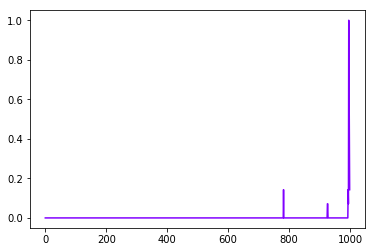

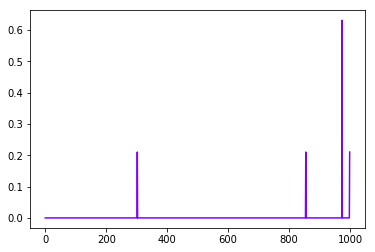

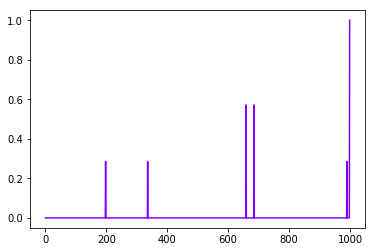

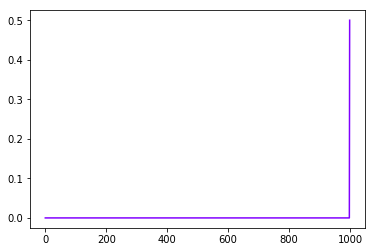

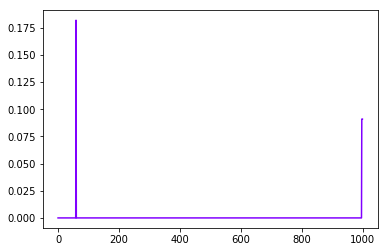

In [481]:
plot_some_customers(0, 5)

Category #2 has 107 members (10%)
Here are some of them :


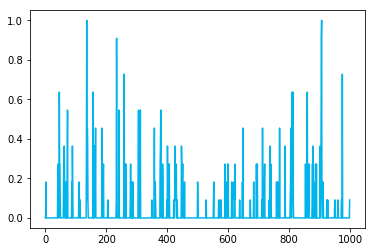

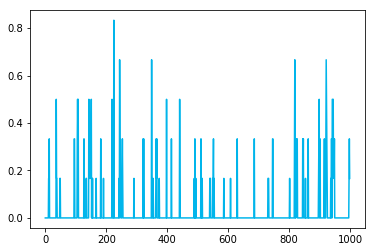

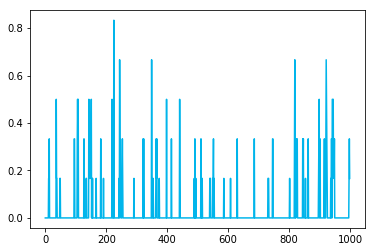

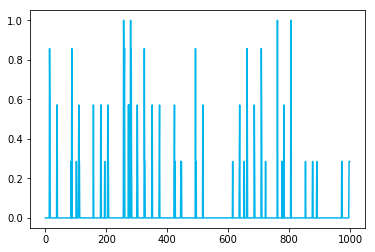

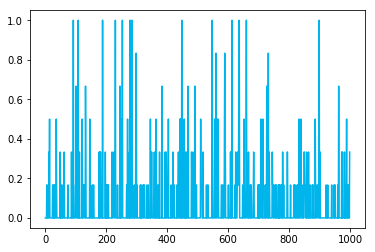

In [482]:
plot_some_customers(1, 5)

Category #3 has 223 members (20%)
Here are some of them :


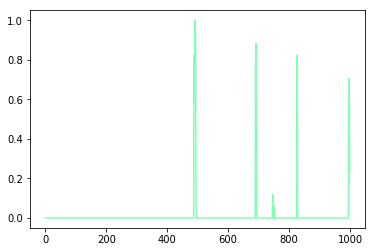

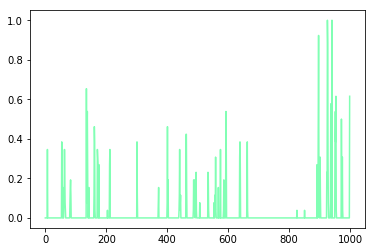

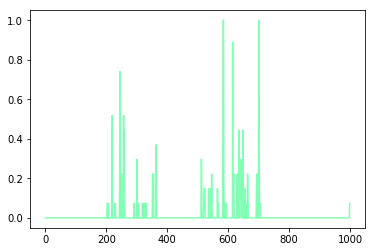

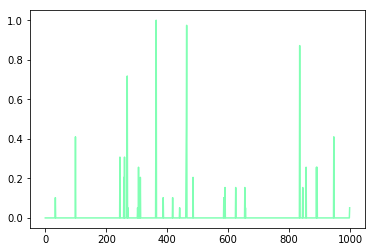

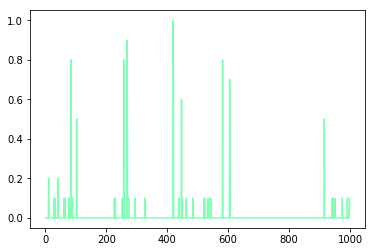

In [491]:
plot_some_customers(2, 5)

Category #4 has 176 members (16%)
Here are some of them :


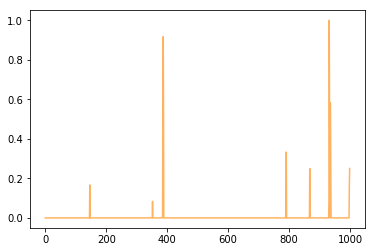

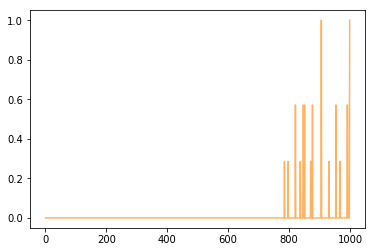

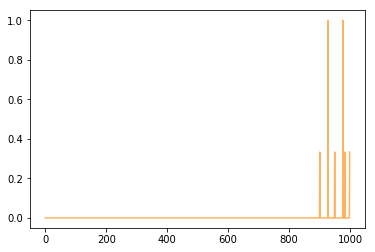

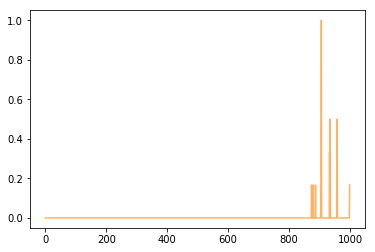

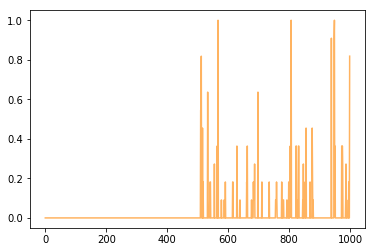

In [478]:
plot_some_customers(3,5)

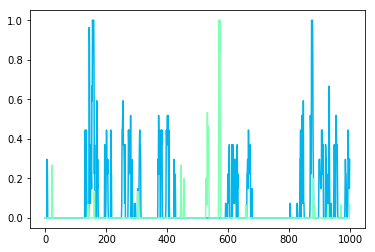

In [489]:
compare_two_clusters(1,2)